<a href="https://colab.research.google.com/github/Pinili/Deep-Learning-for-Satellite-Imagery/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated IAS identification approach using a Machine Learning approach

(Invasive alien species = IAS)

This is an independent thesis-project to classify <i>Rhamnus cathartica</i> using transfer learning in Convolutional Neural Networks (CNN).

All coding dependencies and datasets in this project is published under UWSpace with the original paper titled:
<br>__Identification of Invasive Plant Species using a Machine Learning approach__. 

In [1]:
## saves data on Google Drive + links to datasets
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!ls

gdrive	sample_data


In [3]:
## install latest version, but will cause conflicting import errors with old fastai versions
 !curl -s https://course.fast.ai/setup/colab | bash

## uncomment to install old version of fastai
## !pip install fastai==0.7.0
## !pip install torchtext==0.2.3


Updating fastai...
Done.


In [4]:
## install extra dependencies
!pip install rasterio    #used for transform images into JPG format, when needed, and select bands
!pip install sat-search  #used to easily obtain Sentinel-2A data - Link: https://github.com/sat-utils

    100% |████████████████████████████████| 19.7MB 2.0MB/s 
    100% |████████████████████████████████| 61kB 13.6MB/s 
    100% |████████████████████████████████| 235kB 25.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/9c/59/4d/591519a4f416d5fc87b2823e424b7ec2930623b06c3e25e76e
  Stored in directory: /root/.cache/pip/wheels/be/8d/49/43673c9c16ce8427f1b3a9441cd751b07e25e099b59e01a8f4
Successfully built sat-search sat-stac
google-colab 1.0.0 has requirement requests~=2.18.0, but you'll have requests 2.21.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4
  Found existing installation: python-dateutil 2.5.3
    Uninstalling python-dateutil-2.5.3:
      Successfully uninst

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
## uncomment below to import fastai v0.7 packages instead
## from fastai.imports import *
## from fastai.conv_learner import *
## from fastai.model import *
## from fastai.plots import *


## import fastai v1 packages needed for image classification
from fastai.vision import *
from fastai.metrics import error_rate

## import rasterio + plotting
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt



In [0]:
!ls "/content/gdrive/My Drive"


In [0]:
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'
path = Path(base_dir + 'GEOG490data/')
dest = path
dest.mkdir(parents=True, exist_ok=True)

train_path = path/'train'
classes = [str(f).split('/')[-1] for f in list(train_path.iterdir())]

#path to bands??
#PATH = Path('/home/shakur/GeoProjects/EuroSat/Bands/')
#train_path = PATH/'train'
#classes = [str(f).split('/')[-1] for f in list(train_path.iterdir())]

## Visualization

#### Classes and Size

Rhamnus_cathartica class has 421
Highway class has 100
Residential class has 100
River class has 100


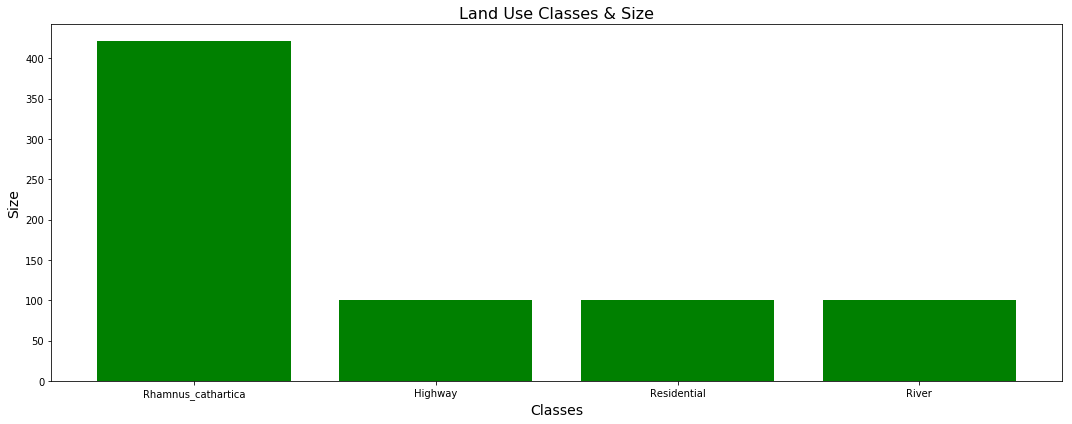

In [14]:
files = []

for i in classes:
    paths =train_path/i
    files.append(list(paths.iterdir())[0])
classes_num = {}
for i in classes:
   
    folders = train_path/i
    classes_num[i] = len(list(folders.iterdir()))
    print(f'{i} class has {len(list(folders.iterdir()))}')
plt.figure(figsize=(15,6))
plt.bar(classes_num.keys(), classes_num.values(), color='green')
plt.title('Land Use Classes & Size', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Size', fontsize=14)
plt.tight_layout()
plt.savefig('classes.jpg')

In [19]:
temp_dataset = rasterio.open(files[0])
temp_dataset.indexes

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)

#### Images

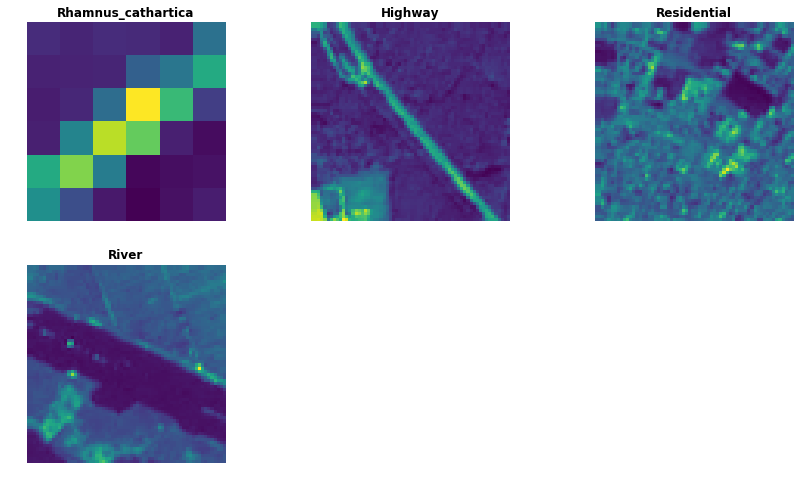

In [23]:
fig = plt.figure(figsize=(12,10))



ax1 = plt.subplot(331);plt.axis('off');plot.show((rasterio.open(files[0]).read(4)), ax=ax1, title=classes[0])
ax2 = plt.subplot(332);plt.axis('off');plot.show((rasterio.open(files[1]).read(4)), ax=ax2, title=classes[1])
ax3 = plt.subplot(333);plt.axis('off');plot.show((rasterio.open(files[2]).read(4)), ax=ax3, title=classes[2])

ax1 = plt.subplot(334);plt.axis('off');plot.show((rasterio.open(files[3]).read(4)), ax=ax1, title=classes[3])
#ax2 = plt.subplot(335);plt.axis('off');plot.show((rasterio.open(files[4])), ax=ax2, title=classes[4])
#ax3 = plt.subplot(336);plt.axis('off');plot.show((rasterio.open(files[5])), ax=ax3, title=classes[5])

#ax1 = plt.subplot(337);plt.axis('off');plot.show((rasterio.open(files[6])), ax=ax1, title=classes[6])
#ax2 = plt.subplot(338);plt.axis('off');plot.show((rasterio.open(files[7])), ax=ax2, title=classes[7])
#ax3 = plt.subplot(339);plt.axis('off');plot.show((rasterio.open(files[8])), ax=ax3, title=classes[8])

plt.tight_layout()

## Model

In [24]:
sz = 224
arch=resnet50
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

NameError: ignored

In [0]:
learn = cnn_learner.pretrained(arch, data, precompute=True)

In [0]:
learn.fit(0.001, 2)

In [0]:
lrf=learn.lr_find(start_lr=1e-5, end_lr=1e-1)

In [0]:
learn.sched.plot_lr()

In [0]:
learn.sched.plot()

In [0]:
learn.fit(1e-5, 3, cycle_len=1)


In [0]:
learn.fit(1e-5, 3, cycle_len=1, cycle_mult=2)

In [0]:
learn.precompute = False 
learn.fit(1e-5, 3, cycle_len=1, cycle_mult=2)

In [0]:
lr = 1e-4
lrs = np.array([lr/12,lr/6,lr])
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2) 

In [0]:
learn.unfreeze()

In [0]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2) 

In [0]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2) 

## Analyzing results & Visualization

In [0]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [0]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)
preds

In [0]:
data.val_ds.fnames[0]

### Invidual Predictions

In [0]:
classes_dict = dict(enumerate(data.classes))
classes_dict

In [0]:
fn = data.val_ds.fnames[0]
pic1 = rasterio.open(str(PATH/fn))
plt.axis('off')
plot.show(pic1)

In [0]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
print(classes_dict[np.argmax(preds)] == 'AnnualCrop')
np.argmax(preds), classes_dict[np.argmax(preds)]

In [0]:
data.val_ds.fnames[2900]

In [0]:
fn = data.val_ds.fnames[2900]
pic2 = rasterio.open(str(PATH/fn))
plt.axis('off')
plot.show(pic2)

In [0]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([2900]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
print(classes_dict[np.argmax(preds)] == 'Pasture')
np.argmax(preds), classes_dict[np.argmax(preds)]

### Confusion Matrix

In [0]:
multi_preds = learn.predict()
preds = np.argmax(multi_preds, axis=1)
preds

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [0]:
plot_confusion_matrix(cm, data.classes, cmap='Reds',figsize=(12,6))
plt.tight_layout()